# A. Importation of libraries and Configs

In [1]:
# Standard libraries
import pandas as pd
import numpy as np

# Non-standard Libaries
from FeatureEngineering.credit_sales_machine_learning import CreditSales

In [2]:
class Config:
    # Path to the pseudonimized revenues dataset
    dataset_dir = r"Database\revenues_pseudonymized.xlsx"
    # Path to the enrollee infos
    enrollees_dir = r"Database\enrollees_pseudonymized.xlsx"
    # Path to the machine learning model parameters
    parameters_dir = r"MachineLearning\parameters.json"

    # Path to cache directory to store preprocessed dataset if needed
    cache_dir = ""
    load_cache = True

    # Path to store transformer results
    results_dir = r"C:\Users\rjbel\Python\Data\Thesis\Results"

    # Class to predict
    target_feature = 'dtp_bracket'
    # Test size in %
    test_size = 0.3


args = Config()

# B. Loading of datasets

## 1. Revenues

In [3]:
df_revenues = pd.read_excel(args.dataset_dir)

In [4]:
df_revenues

,entry_number,entry_date,due_date,school_year,student_id_pseudonimized,category_name,discount_refund_applied_to,amount_due,amount_paid,account_name,receivables
0,0,2025-10-13,2025-10-13,2014,9XBPS6GQ,Form 137,NaN,150.0,150.0,G-Cash,0.0
1,1,2016-01-01,2016-01-01,2016,QCNXOF71,Back Account,NaN,3524.0,0.0,Not Applicable,3524.0
2,2,2016-01-01,2016-01-01,2016,UFN5RBCA,Back Account,NaN,9831.0,0.0,Not Applicable,9831.0
3,3,2016-01-01,2016-01-01,2016,CATF26JR,Back Account,NaN,9240.0,0.0,Not Applicable,9240.0
4,4,2016-01-01,2016-01-01,2016,TE11Z2LJ,Back Account,NaN,5886.0,0.0,Not Applicable,5886.0
...,...,...,...,...,...,...,...,...,...,...,...
51350,53666,2026-02-12,2026-02-12,2026,2MKL4UPP,Reservation Fee - SpEd,NaN,3000.0,3000.0,G-Cash,0.0
51351,53667,2026-02-13,2026-02-13,2026,NWMMMGTZ,Reservation Fee - SpEd,NaN,3000.0,3000.0,Cash,0.0
51352,53668,2026-02-13,2026-02-13,2026,GZ1OAOTE,Assesment Fee,NaN,600.0,600.0,Cash,0.0
51353,53669,2026-02-13,2026-02-13,2026,81GYBAT1,Assesment Fee,NaN,600.0,600.0,G-Cash,0.0


## 2. Enrollees

In [5]:
df_enrollees = pd.read_excel(args.enrollees_dir)

## 3. Credit Sales

In [6]:
cs = CreditSales(df_revenues, df_enrollees)
df_credit_sales = cs.show_data()

Single due date records: 10029
Multiple due date records: 257


In [7]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket
0,2022,02PNVPI5,Kn2-C-1st,2800.0,0.0,0.0,2800.0,2022-09-09,2022-09-06,2022-08-04,...,29227.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
1,2022,02PNVPI5,Kn2-C-2nd,2800.0,0.0,0.0,2800.0,2022-11-05,NaT,2022-09-06,...,32027.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
2,2022,02PNVPI5,Kn2-OF-2nd,2267.0,0.0,0.0,2267.0,2022-12-05,NaT,2022-09-06,...,34294.0,30227.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
3,2022,02PNVPI5,Surcharge,336.0,0.0,0.0,336.0,2022-12-16,NaT,2022-12-12,...,38520.0,31027.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
4,2022,02PNVPI5,Events - Foundation Day,490.0,0.0,0.0,490.0,2022-12-16,NaT,2022-12-12,...,38520.0,31027.0,0,0.0,0.0,1.0,0.0,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10281,2025,ZXPL0CI9,G06-C-2nd,5800.0,0.0,0.0,5800.0,2025-10-03,2025-10-27,2025-09-09,...,191320.0,185520.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10282,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10283,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10284,2025,ZXPL0CI9,G06-C-4th,5800.0,0.0,0.0,5800.0,2026-02-06,2026-02-09,2026-01-08,...,208970.0,203170.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days


In [8]:
df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 'dtp_bracket'], inplace=True)

# Drop plans D, E, and not enrolled
df_credit_sales = df_credit_sales[
    (df_credit_sales['plan_type_Plan - D'] != 1) &
    (df_credit_sales['plan_type_Plan - E'] != 1) &
    (df_credit_sales['plan_type_nan'] != 1)
]

In [9]:
df_credit_sales

,school_year,student_id_pseudonimized,category_name,gross_receivables,amount_discounted,adjustments,credit_sale_amount,due_date,date_fully_paid,last_payment_date,...,amount_due_cumsum,amount_paid_cumsum,opening_balance,plan_type_Plan - A,plan_type_Plan - B,plan_type_Plan - C,plan_type_Plan - D,plan_type_Plan - E,plan_type_nan,dtp_bracket
15,2021,07EGT7GO,Kn2-C-3rd,2800.0,0.0,0.0,2800.0,2022-02-07,2022-01-29,2022-01-03,...,30960.0,30960.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
16,2021,07EGT7GO,Kn2-C-4th,2800.0,0.0,0.0,2800.0,2022-04-04,2022-03-31,2022-01-29,...,33760.0,33760.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
21,2025,07HFC4W3,Kn2-C-4th,5400.0,-700.0,0.0,4700.0,2026-02-06,2026-01-29,2025-12-05,...,61737.0,61037.0,0,0.0,0.0,1.0,0.0,0.0,0.0,on_time
29,2019,08GNGU9D,G04-OF-2nd,2900.0,0.0,0.0,2900.0,2019-12-06,2019-12-14,2019-10-29,...,60882.0,55117.0,0,0.0,1.0,0.0,0.0,0.0,0.0,30_days
34,2022,09ISZU99,G02-OF-Full,7000.0,-1032.0,0.0,5968.0,2022-07-16,2022-10-07,2022-07-14,...,92285.0,85285.0,0,1.0,0.0,0.0,0.0,0.0,0.0,90_days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10280,2025,ZXPL0CI9,Extra Curricular - Others,1700.0,0.0,0.0,1700.0,2025-08-28,2025-09-09,2025-08-05,...,185520.0,183820.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10281,2025,ZXPL0CI9,G06-C-2nd,5800.0,0.0,0.0,5800.0,2025-10-03,2025-10-27,2025-09-09,...,191320.0,185520.0,0,0.0,0.0,1.0,0.0,0.0,0.0,30_days
10282,2025,ZXPL0CI9,G06-OF-2nd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days
10283,2025,ZXPL0CI9,G06-C-3rd,5800.0,0.0,0.0,5800.0,2025-12-05,2026-01-08,2025-10-27,...,203170.0,191570.0,0,0.0,0.0,1.0,0.0,0.0,0.0,60_days


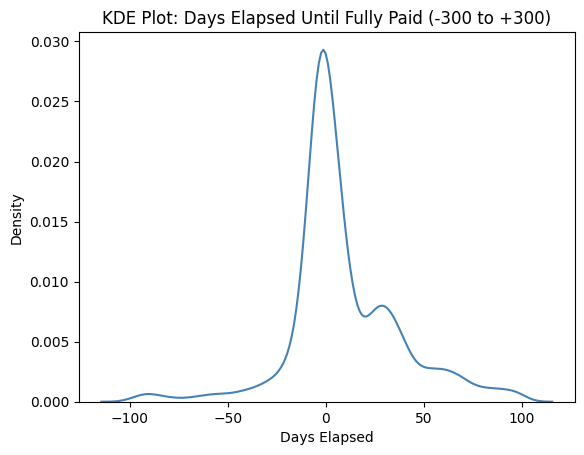

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Clean the column: drop NaNs and empty strings
cleaned_days = df_credit_sales['days_elapsed_until_fully_paid']
cleaned_days = cleaned_days.replace("", np.nan).dropna()

# Filter to range -300 to +300
filtered_days = cleaned_days[(cleaned_days >= -100) & (cleaned_days <= 100)]

# KDE plot
sns.kdeplot(
    x=filtered_days,
    fill=False,
    color="steelblue"
)

plt.title("KDE Plot: Days Elapsed Until Fully Paid (-300 to +300)")
plt.xlabel("Days Elapsed")
plt.ylabel("Density")
plt.show()

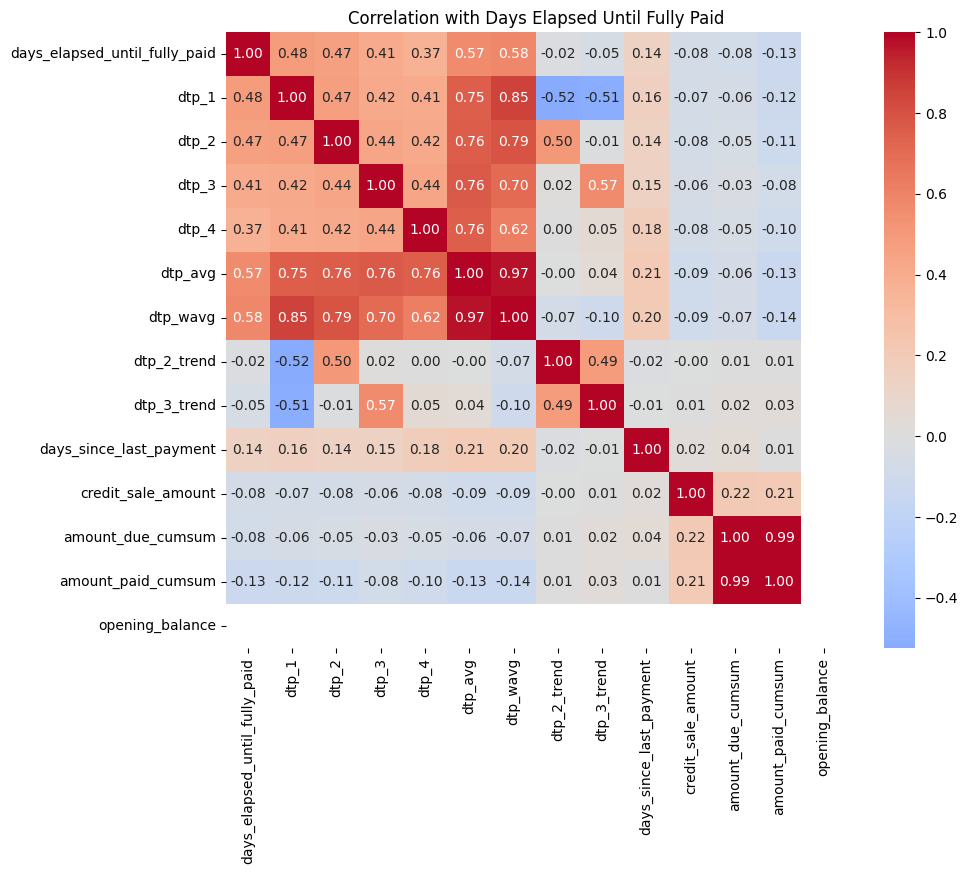

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df_credit_sales = df_credit_sales.dropna(subset=['dtp_1', 'dtp_2', 'dtp_3', 'dtp_4'])

# Select relevant columns
cols = ['days_elapsed_until_fully_paid', 
        'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 
        'dtp_avg', 'dtp_wavg', 'dtp_2_trend',
        'dtp_3_trend', 'days_since_last_payment',
        'credit_sale_amount', 'amount_due_cumsum',
        'amount_paid_cumsum', 'opening_balance']

# Compute correlation matrix
corr = df_credit_sales[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation with Days Elapsed Until Fully Paid")
plt.show()

In [12]:
drop_columns = ['school_year', 'student_id_pseudonimized', 'category_name',
       'gross_receivables', 'amount_discounted', 'adjustments', 'due_date', 'date_fully_paid',
       'last_payment_date', 'days_elapsed_until_fully_paid',
       'plan_type_Plan - D', 'plan_type_Plan - E', 'plan_type_nan']

df_data = df_credit_sales.drop(columns=drop_columns)

# C. Machine Learning Pipelines

In [13]:
df_data.columns

Index(['credit_sale_amount', 'dtp_1', 'dtp_2', 'dtp_3', 'dtp_4', 'dtp_avg',
       'dtp_wavg', 'dtp_2_trend', 'dtp_3_trend', 'days_since_last_payment',
       'amount_due_cumsum', 'amount_paid_cumsum', 'opening_balance',
       'plan_type_Plan - A', 'plan_type_Plan - B', 'plan_type_Plan - C',
       'dtp_bracket'],
      dtype='object')

In [14]:
from MachineLearning.Utils.data_preparation import DataPreparer

# Initialize the preparer
preparer = DataPreparer(df_data, args.target_feature, test_size=args.test_size)

# Run preprocessing
preparer.prep_data()

# Load the train/test splits
X_train = preparer.X_train
X_test  = preparer.X_test
y_train = preparer.y_train
y_test  = preparer.y_test

Partitioning the datasets...
Applying manual oversampling...


In [ ]:
from MachineLearning import (
    AdaBoostPipeline,
    DecisionTreePipeline,
    GaussianNaiveBayesPipeline,
    KnearestNeighborPipeline,
    RandomForestPipeline,
    XGboostPipeline,
    MultiLayerPerceptronPipeline,
    TransformerPipeline,
)

models = {
    "ada_boost": AdaBoostPipeline,
    "decision_tree": DecisionTreePipeline,
    "gaussian_naive_bayes": GaussianNaiveBayesPipeline,
    "knn": KnearestNeighborPipeline,
    "random_forest": RandomForestPipeline,
    "xgboost": XGboostPipeline,
    "nn_mlp": MultiLayerPerceptronPipeline,
    #"nn_rnn": RecurrentNeuralNetworkPipeline,
    "nn_transformer": TransformerPipeline
}

c:\Users\rjbel\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import pandas as pd
from MachineLearning.Utils.load_parameters import ParameterLoader

# Load parameters from JSON
loader = ParameterLoader(args.parameters_dir)

all_results = []  # list to gather results

for model_name, pipeline_class in models.items():
    param_list = loader.get_parameters(model_name)

    for param in param_list:
        print(f"Running {model_name} with parameters: {param}")

        pipeline = pipeline_class(X_train, X_test, y_train, y_test,
                                  args,
                                  param)

        # Capture results from pipeline
        result = pipeline.build_model().train().evaluation().show_results()

        # Add metadata (model name + parameters)
        result["model"] = model_name
        result["parameters"] = str(param)

        all_results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Export to Excel
results_df.to_excel("model_results.xlsx", index=False)
print("All results saved to model_results.xlsx")

Running ada_boost with parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 0.01, 'n_estimators': 150}
Running ada_boost with parameters: {'learning_rate': 0.1, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Running ada_boost with parameters: {'learning_rate': 0.5, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 1.0, 'n_estimators': 50}
Running ada_boost with parameters: {'learning_rate': 1.0, 'n_estimators': 150}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 1}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 3}
Running decision_tree with parameters: {'max_depth': 10, 'min_samples_leaf': 5}
Running decision_tree with parameters: {'max_depth': 20, 'min_samples_leaf': 1}
Running decision_tree with parameters: {'max_depth': 20, 'min_samples_leaf': 3}
Running decision_tree with parameters: {'max_dept

c:\Users\rjbel\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rjbel\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\rjbel\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\rjbel\AppData\Local\Programs\Python\Pytho

Running knn with parameters: {'n_neighbors': 3, 'weights': 'distance'}
Running knn with parameters: {'n_neighbors': 5, 'weights': 'uniform'}
Running knn with parameters: {'n_neighbors': 5, 'weights': 'distance'}
Running knn with parameters: {'n_neighbors': 7, 'weights': 'uniform'}
Running knn with parameters: {'n_neighbors': 7, 'weights': 'distance'}
Running random_forest with parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Running random_forest with parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Running random_forest with parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
Running random_forest with parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}
Running random_forest with parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}
Running random_forest with parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}
Running random_forest with parameters: {'

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 960.06it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.376074
2,No log,1.378237
3,1.359373,1.356799
4,1.359373,1.383031
5,1.306439,1.331529
6,1.306439,1.334442
7,1.306439,1.362854
8,1.254210,1.346768
9,1.254210,1.365875
10,1.195167,1.380277


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 12, 'num_heads': 12, 'd_model': 768, 'epochs': 100}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 926.83it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.347540
2,No log,1.346657
3,1.340123,1.353268
4,1.340123,1.375504
5,1.254192,1.360791
6,1.254192,1.347273
7,1.254192,1.410604
8,1.192692,1.358944
9,1.192692,1.413375
10,1.162418,1.402341


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 12, 'num_heads': 12, 'd_model': 768, 'epochs': 200}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 959.18it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_D

[INFO] Using device: cuda


Epoch,Training Loss,Validation Loss
1,No log,1.311165
2,No log,1.367255
3,1.323412,1.373565
4,1.323412,1.370779
5,1.225541,1.355353
6,1.225541,1.351657
7,1.225541,1.439096
8,1.183911,1.364387
9,1.183911,1.407480
10,1.156780,1.442842


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 2, 'num_heads': 4, 'd_model': 128, 'epochs': 50}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 944.69it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.307207
2,No log,1.362265
3,1.306532,1.378520
4,1.306532,1.386561
5,1.198390,1.347395
6,1.198390,1.353010
7,1.198390,1.410924
8,1.161159,1.395910
9,1.161159,1.422459
10,1.142776,1.434493


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 2, 'num_heads': 4, 'd_model': 128, 'epochs': 100}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 962.01it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_D

[INFO] Using device: cuda


Epoch,Training Loss,Validation Loss
1,No log,1.368530
2,No log,1.407137
3,1.374923,1.389618
4,1.374923,1.426696
5,1.328281,1.307380
6,1.328281,1.312466
7,1.328281,1.377328
8,1.274912,1.358162
9,1.274912,1.384930
10,1.241385,1.335232


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 2, 'num_heads': 4, 'd_model': 128, 'epochs': 200}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 871.01it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.373353
2,No log,1.363216
3,1.362795,1.332825
4,1.362795,1.386074
5,1.292186,1.374054
6,1.292186,1.331133
7,1.292186,1.421644
8,1.244998,1.334540
9,1.244998,1.390478
10,1.210430,1.384763


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 4, 'num_heads': 8, 'd_model': 256, 'epochs': 50}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 924.29it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.394617
2,No log,1.379573
3,1.380026,1.392277
4,1.380026,1.395382
5,1.324939,1.341559
6,1.324939,1.317658
7,1.324939,1.350142
8,1.276983,1.349720
9,1.276983,1.385344
10,1.239057,1.388331


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 4, 'num_heads': 8, 'd_model': 256, 'epochs': 100}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 924.35it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.365908
2,No log,1.383337
3,1.356234,1.377474
4,1.356234,1.375360
5,1.260474,1.327412
6,1.260474,1.343472
7,1.260474,1.401551
8,1.206342,1.357010
9,1.206342,1.388302
10,1.172682,1.423785


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 4, 'num_heads': 8, 'd_model': 256, 'epochs': 200}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 948.40it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.373353
2,No log,1.363216
3,1.362795,1.332825
4,1.362795,1.386074
5,1.292186,1.374054
6,1.292186,1.331133
7,1.292186,1.421644
8,1.244998,1.334540
9,1.244998,1.390478
10,1.210430,1.384763


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 6, 'num_heads': 8, 'd_model': 512, 'epochs': 50}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 922.47it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.394617
2,No log,1.379573
3,1.380026,1.392277
4,1.380026,1.395382
5,1.324939,1.341559
6,1.324939,1.317658
7,1.324939,1.350142
8,1.276983,1.349720
9,1.276983,1.385344
10,1.239057,1.388331


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 6, 'num_heads': 8, 'd_model': 512, 'epochs': 100}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 920.12it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.365908
2,No log,1.383337
3,1.356234,1.377474
4,1.356234,1.375360
5,1.260474,1.327412
6,1.260474,1.343472
7,1.260474,1.401551
8,1.206342,1.357010
9,1.206342,1.388302
10,1.172682,1.423785


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


Running nn_transformer with parameters: {'num_layers': 6, 'num_heads': 8, 'd_model': 512, 'epochs': 200}
[INFO] Auto-detected 4 classes: [0, 1, 2, 3]


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 930.02it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


[INFO] Using device: cuda


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss
1,No log,1.373353
2,No log,1.363216
3,1.362795,1.332825
4,1.362795,1.386074
5,1.292186,1.374054
6,1.292186,1.331133
7,1.292186,1.421644
8,1.244998,1.334540
9,1.244998,1.390478
10,1.210430,1.384763


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


[INFO] Deleted checkpoint directory after loading best model.


All results saved to model_results.xlsx
